# [Selected Problems in Machine Learning (NPFL097)](https://ufal.mff.cuni.cz/courses/npfl097)

In [82]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from glob import glob

In [2]:
glob("data/*")

['data/dictionary.txt', 'data/test_data.tsv', 'data/training_data.tsv']

In [3]:
train = np.genfromtxt("data/training_data.tsv", delimiter="\t", dtype=np.int32)
test = np.genfromtxt("data/test_data.tsv", delimiter="\t", dtype=np.int32)
dictionary = np.genfromtxt("data/dictionary.txt", dtype=np.string_)

In [4]:
dictionary

array([b'aarp', b'abandon', b'abandoned', ..., b'zogbys', b'zone',
       b'zones'], dtype='|S40')

## Question 1.

**Using the training data, compute the maximum likelihood estimation over the words across
the documents. Plot a histogram showing 20 most probable words.**

The model is just a Multinomial distribution, that is

$$
p(x | \pi, n) = \binom{n!}{x_1!,x_2!,\ldots,x_m!} \prod_{i=1}^m \pi_i^{x_i} = n! \prod_{i=1}^m \frac{\pi_i^{x_i}}{x_i!}
$$

where $\pi_i$ is the probability of $i-th$ word, $x_i$ is the number of occurences of the $i-th$ word, $m$ is the number of words in the dictionary, and $n$ is the total number of occurences.

We compute $\pi_i$ using MLE, that is simply

$$
\pi_i = \frac{x_i}{n}.
$$

In [5]:
m = len(dictionary)

def compute_counts(document):
    counts = np.zeros(m, np.int32)
    
    for document_id, word_id, count in document:
        counts[word_id - 1] += count
        
    return counts

In [6]:
counts = compute_counts(train)
n = counts.sum()

pi_mle = counts.astype(np.float32) / n

Most probable word is simply the one with the highest MLE

In [7]:
dictionary[np.argmax(pi_mle)]

b'bush'

In [8]:
max(counts), max(pi_mle)

(3833, 0.014097198214036146)

In [9]:
max_mle = pi_mle[np.argsort(pi_mle)[-20:]]
most_probable_words = dictionary[np.argsort(pi_mle)[-20:]]

In [10]:
max_mle

array([0.00340937, 0.00342776, 0.00343143, 0.00344615, 0.00352706,
       0.00353441, 0.00384335, 0.00388749, 0.00401989, 0.00432883,
       0.00450537, 0.00468558, 0.00497245, 0.00498716, 0.00534392,
       0.00535863, 0.00570067, 0.00841124, 0.00967642, 0.0140972 ])

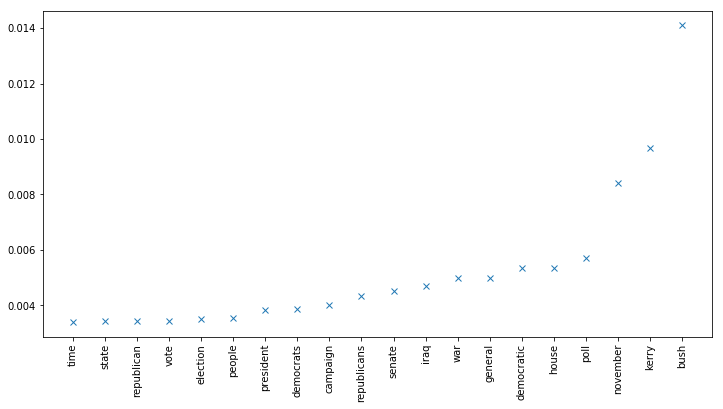

In [11]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=90)
plt.plot(most_probable_words, max_mle, "x")

## Question 2.

**What is the log-probability of the test data if we use the MLE model from question 1)? Note
that the test set contains words which are not contained in the training set. Explain**

The log probability is then

$$
\begin{align}
\log \left( n! \prod_{i=1}^m \frac{\pi_i^{x_i}}{x_i!} \right) &= \log n! + \sum_{i=1}^m x_i \log \pi_i - \sum_{i=1}^m \log x_i! \\
&= \sum_{i=1}^n \log i + \sum_{i=1}^m x_i \log \pi_i - \sum_{i=1}^m \sum_{j=1}^{x_i} \log j
\end{align}
$$

In [12]:
def logfact(k):
    return np.sum(np.log2(np.array(range(int(k)), dtype=np.float32) + 1))

def log_prob(dataset, pi):
    counts = compute_counts(dataset)
    
    return np.sum(counts * np.log2(pi))
    
#     t1 = np.sum(logfact(n))
#     t2 = np.sum(counts * np.log2(pi))
#     t3 = np.sum([logfact(c) for c in counts])

#     return t1 + t2 - t3

In [13]:
log_prob(test, pi_mle)

/home/darth/.venv/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log2
  import sys


-inf

The log probability is *-inf* since there are words in the test set that are not present in the training set, and as such their probability is $0$, and $\log(0) = -\infty$.

## Question 3.

**Instead of MLE, do the Bayesian inference model on the training data using a symmetric Dirichlet prior with a concentration parameter 0.1. Provide a formula for the predictive distribution.**

I'm not sure what the *predictive distribution* is in this context, since it could be either for the Dirichlet-Categorical or the Dirichlet-Multinomial, so I'm going to provide both :)

In general, posterior predictive is

$$
p(X | D) = \int p(X|\theta) p(\theta|D)\ d\theta
$$

For Dirichlet-Categorical ($Dir(\alpha + D)$ means the posterior for $p(\alpha|D)$, which for Dirichlet-Categorical is just adding the psuedo-counts together, where $D$ are the pseudo-counts, $\boldsymbol\pi$ is the Categorical probabilities, $\boldsymbol\alpha$ are the concentrations).

$$
\begin{align}
p(X=j | D) &= \int p(X=j|\boldsymbol\pi) p(\boldsymbol\pi|D)\ d\pi \\
&= \int Cat(X=j|\boldsymbol\pi) p(\boldsymbol\pi|D)\ d\pi \\
&= \int \boldsymbol\pi_j p(\boldsymbol\pi|D) \ d\pi 
\end{align}
$$

splitting the integral into $\pi_{\neg j} = (\pi_1, \ldots, \pi_{j-1},\pi_{j+1},\ldots, \pi_m)$ and $\pi_j$ and writing it as a double integral

$$
\begin{align}
&= \int \int \boldsymbol\pi_j p(\boldsymbol\pi|D) \ d\pi_{\neg j}\ d\pi_j \\
&= \int \pi_j \int p(\boldsymbol\pi|D) \ d\pi_{\neg j}\ d\pi_j \\
&= \int \pi_j p(\pi_j) d\pi_j
\end{align}
$$

where the last equation is simply because of marginalization. This is simply 

$$
E[\pi_j | D] = \frac{\alpha_j + x_j}{\sum_{i=1}^m (\alpha_i + x_i)}
$$

**In any case, I'll simply assume the Dirichlet-Categorical case in the rest of the code.**

In [18]:
def dirichlet_categorical_posterior(dataset, alpha):
    counts = compute_counts(dataset)
    n = counts.sum()

    return (counts + alpha) / (n + m*alpha)

In [19]:
pi_posterior = dirichlet_categorical_posterior(train, 0.1)
pi_posterior

array([1.50409812e-05, 6.27318971e-05, 4.80577691e-05, ...,
       6.27318971e-05, 1.17759877e-04, 2.23780452e-05])

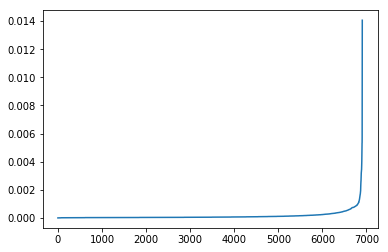

In [20]:
plt.plot(np.sort(pi_posterior))

## Question 4:

**Using the Bayesian model from question 3, compute the log probability and the per-word perplexity of the test data.**

In [21]:
print(f"Train log P = {log_prob(train, pi_posterior)}")
print(f"Test log P = {log_prob(test, pi_posterior)}")

Train log P = -3081803.2292384217
Test log P = -2231753.5169690647


$$
\exp\left(-\log p(data) / n\right) = \exp\left(-\log \prod_{i=1}^m \pi_i^{x_i} / n\right) = \exp\left(-\sum_{i=1}^m x_i \log \pi_i / n \right)
$$

In [22]:
def per_word_perplexity(dataset, pi):
    counts = compute_counts(dataset)
    n = counts.sum()
        
    logp = log_prob(dataset, pi)

    return 2**(- logp / n)

In [23]:
print(f"Per word perplexity = {per_word_perplexity(test, pi_posterior)}")

Per word perplexity = 2697.1068182222193


# Question 5:

**Compute the per-word perplexity of the test data using uniform multinomial dictribution
over the dictionary. Compare this value to the previously computed perplexities and explain.**

In [24]:
pi_uniform = np.array([1/len(dictionary) for _ in range(len(dictionary))])

print(f"Uniform prior perplexity = {per_word_perplexity(test, pi_uniform)}")

Uniform prior perplexity = 6905.99999999999


In the uniform case we get exactly

$$
2^{-\log 1/m} = \frac{1}{2^{\log 1/m}} = m
$$

which is the size of the dictionary.

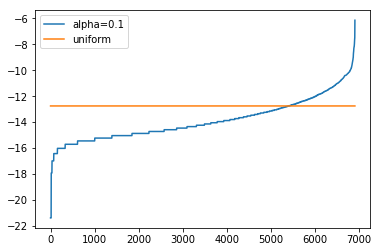

In [25]:
plt.plot(np.log2(np.sort(pi_posterior)), label="alpha=0.1")
plt.plot(np.log2(np.sort(pi_uniform)), label="uniform")
plt.legend()

## Question 6:

**Implement the Latent Dirichlet allocation topic model as described in the previous lectures.
Set the hyperparameters α = 0.1, γ = 0.1 and set number of topics K = 20. Plot the topic
posteriors of the document 1 as a function of the number of Gibbs sweeps, up to 20 sweeps.
Comment on these.**

The general model parameters:

- $D$ is the number of documents.
- $m$ is the number of unique words in the dictionary.
- $N_d$ is the number of words in document $D$, these are not the same.
- $K$ is the number of topics, fixed at $20$.
- $\alpha$ and $\gamma$ are prior parameters set both at fixed $0.1$ for a symmetric Dirichlet
- $z_{nd}$ assigns a topic to each position $n$ in document $d$. This can't be a matrix since the documents have varying length.
- $w_{nd}$ assigns a word to each position $n$ in document $d$. These are drawn from the distribution for $\beta_{z_{nd}}$

and the counters:

- $c_{kd}$ ... number of words assigned (total counts) to topic $k$ in document $d$.
- $c_{km}$ ... number of times a word $m$ is assigned to topic $k$.
- $c_k$ ... number of words assigned (total counts) to topic $k$ across all documents.

In [68]:
D = len(np.unique(train[:,0]))

# Number of word positions in each document
N_D = np.zeros((D,), dtype=np.int32)

for document_id, word_id, count in train:
    N_D[document_id - 1] += count

Each document has different size, which makes things a bit more complicated implementation wise.

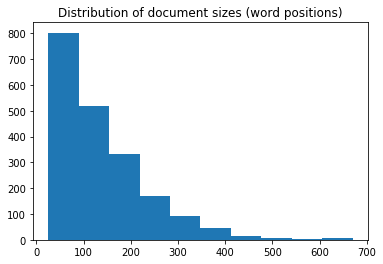

In [69]:
plt.title("Distribution of document sizes (word positions)")
plt.hist(N_D)
plt.show()

In [70]:
K = 20
alpha = 0.1
gamma = 0.1
M = len(dictionary)

z_DN = [np.random.randint(0, K, size=N_D[d]) for d in range(D)]

This part doesn't make much sense, but there is no other way we can get $w_{nd}$ than by expanding the counts into a sequence of words.

In [71]:
w_DN = []

for d in range(D):
    train_d = train[train[:,0] == d+1][:,1:3]
    
    res = np.zeros(0, dtype=np.int32)
    
    for word_id, count in train_d:
        repeats = np.repeat(word_id - 1, count)
        
        res = np.hstack((res, repeats))
        
    w_DN.append(res)

A simple check, since we should have the same number of topic assignemnts for word positions as the actual words.

In [72]:
assert sum(map(len, w_DN)) == sum(map(len, z_DN))

Now we just compute the counts

In [73]:
c_KD = np.zeros((K, D), dtype=np.int)
c_KM = np.zeros((K, M), dtype=np.int)
c_K = np.zeros((K,), dtype=np.int)

for d, document in enumerate(z_DN):
    for n, k in enumerate(document):
        m = w_DN[d][n]
        
        c_KD[k, d] += 1
        c_KM[k, m] += 1
        c_K[k] += 1

In [74]:
# All the counts should sum to each other
assert np.sum(c_KM) == np.sum(c_K)
assert np.sum(c_KD) == np.sum(c_K)
assert np.sum(c_KD) == np.sum(c_KM)

In [75]:
from tqdm import tqdm, tqdm_notebook

In [76]:
n_iter = 20

sweeps = []

for i in tqdm(range(n_iter)):
    for d in range(D):
        for n in range(N_D[d]):
            z_nd = z_DN[d][n]
            w_nd = w_DN[d][n]
            
            c_KD[z_nd, d] = max(0, c_KD[z_nd, d] - 1)
            c_KM[z_nd, w_nd] = max(0, c_KM[z_nd, w_nd] - 1)
            c_K[z_nd] = max(0, c_K[z_nd] - 1)

            p = np.zeros((K,), dtype=np.float32)
            
            for k in range(K):
                a = (alpha + c_KD[k, d]) / (K * alpha + N_D[d] - 1)
                b = (gamma + c_KM[k, w_nd]) / (M * gamma + c_K[k])
                p[k] = a*b
                
            p /= sum(p)
            assert np.allclose(1, sum(p)), f"sum(P) = {sum(p)}"           
                
            k = np.random.choice(range(len(p)), p=p) # sample k
            
            z_nd = k
            
            c_KD[k, d] += 1
            c_KM[k, w_nd] += 1
            c_K[k] += 1
            
        if d == 0:
            sweeps.append((p, c_KD.copy(), c_KM.copy(), c_K.copy()))

100%|██████████| 20/20 [23:03<00:00, 69.48s/it]


**Plot the topic
posteriors of the document 1 as a function of the number of Gibbs sweeps, up to 20 sweeps.**

Text(0.5, 1.0, 'Posterior probabilities for d1')

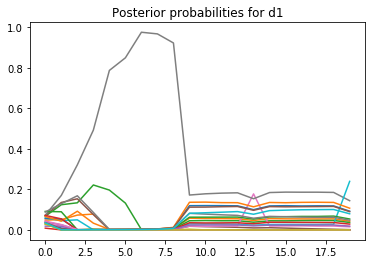

In [83]:
ps = [s[0] for s in sweeps]

for k in range(20):
    plt.plot([p[k] for p in ps])

plt.title("Posterior probabilities for d1")

We can see how they stabilize with higher number of sweeps.

## Question 7

**Compute the word entropy for each of the topics as a function of the number of Gibbs
sweeps. (1 pts)**

Definition copied over from above for clarity:

- $c_{kd}$ ... number of words assigned (total counts) to topic $k$ in document $d$.
- $c_{km}$ ... number of times a word $m$ is assigned to topic $k$.
- $c_k$ ... number of words assigned (total counts) to topic $k$ across all documents.

In [102]:
per_topic_entropy = []

for p, c_KD, c_KM, c_K in sweeps:
    sweep_entropies = np.zeros((K,), dtype=np.float32)
    
    for k in range(K):
        p_KM = c_KM[k,:] / sum(c_KM[k,:])
        
        # Avoiding zero count words
        p_KM = p_KM[p_KM > 0]
        
        sweep_entropies[k] = -sum(p_KM * np.log2(p_KM))
    
    per_topic_entropy.append(sweep_entropies)

Text(0.5, 1.0, 'Per topic entropy')

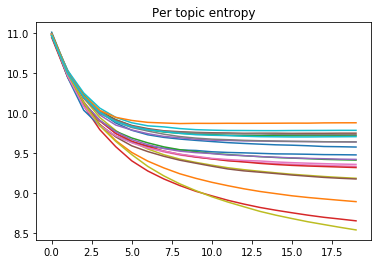

In [105]:
plt.plot(per_topic_entropy)
plt.title("Per topic entropy")

At lower number of sweeps, the entropy is high as the distribution is not stabilized and assignments are random. As the number of sweeps increase, the word distribution stabilizes more towards higher probability words (as the $0.1$ Dirichlet prior suggests), which leads to higher mass on few words and lower overall entropy.

## Question 8

**Show histograms of the most frequent 20 words of a three chosen topics after 20 Gibbs
sweeps. (0.5 pts)**

Definition copied over from above for clarity:

- $c_{kd}$ ... number of words assigned (total counts) to topic $k$ in document $d$.
- $c_{km}$ ... number of times a word $m$ is assigned to topic $k$.
- $c_k$ ... number of words assigned (total counts) to topic $k$ across all documents.

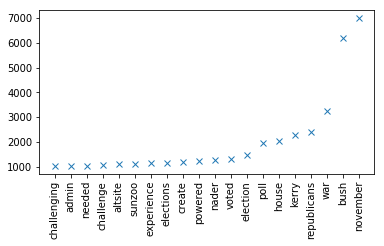

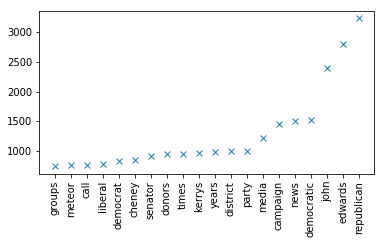

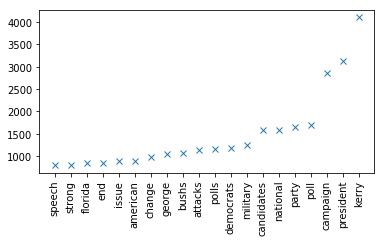

In [126]:
for k in [1,2,4]:
    plt.figure(figsize=(6,3))
    plt.xticks(rotation=90)
    c_M = c_KM[k, :] # Counts of words in topic k
    plt.plot(dictionary[np.argsort(c_M)[-20:]], np.sort(c_M)[-20:], "x")
    print()

Doesn't seem to be working as expected, even among the better groups there are overlaps in words among the topics.

## Question 9

**Compute the per-word perplexity of the test data for the state after 20 Gibbs sweeps, and
compare it to the previously computed perplexities. Are 20 Gibbs sweeps adequate? (1 pts)**

In [130]:
def compute_counts(document):
    counts = np.zeros(M, np.int32)
    
    for document_id, word_id, count in document:
        counts[word_id - 1] += count
        
    return counts

def per_word_perplexity(dataset, pi):
    counts = compute_counts(dataset)
    n = counts.sum()
        
    logp = log_prob(dataset, pi)

    return 2**(- logp / n)


c_KM1 = sweeps[-1][2]

word_p = np.zeros((M,), dtype=np.float32)

for m in range(M):
    word_p[m] = np.sum(c_KM1[:, m]) / np.sum(c_KM1)

per_word_perplexity(test, word_p)

/home/darth/.venv/tf-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log2
  import sys


inf

It seems 20 Gibbs sweeps are not enough, since we still get zero probability words.

## Question 10

**Try to change the number of topics K, the hyperparameters α and β and the number of
Gibbs sweeps. How the performance changes? (1 pts)**

Didn't do because it's too slow and I'm already behind the deadline.